## Assignment 2.4: Text classification via CNN (20 points)

In this assignment you should perform sentiment analysis of the IMDB reviews based on CNN architecture. Read carefully [Convolutional Neural Networks for Sentence Classification](https://arxiv.org/pdf/1408.5882.pdf) by Yoon Kim.

In [0]:
import numpy as np
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext import datasets
from torchtext.data import Field, LabelField
from torchtext.data import Iterator

device='cuda'

### Preparing Data

In [0]:
TEXT = Field(sequential=True, lower=True, batch_first=True)
LABEL = LabelField(batch_first=True)

In [0]:
train, tst = datasets.IMDB.splits(TEXT, LABEL)
trn, vld = train.split()

In [0]:
LABEL.build_vocab(trn)

In [71]:
%%time
TEXT.build_vocab(trn)

CPU times: user 1.23 s, sys: 3.95 ms, total: 1.23 s
Wall time: 1.23 s


### Creating the Iterator (2 points)

Define an iterator here

In [0]:
train_iter, val_iter, test_iter = Iterator.splits(
        (trn, vld, tst),
        batch_sizes=(8, 8, 8),
        sort=False,
        sort_key=lambda x: len(x),
        sort_within_batch=False,
        device='cuda',
        repeat=False
)

### Define CNN-based text classification model (8 points)

In [0]:
class CNN(nn.Module):
    def __init__(self, V, D, kernel_sizes, batch_size=8, dropout=0.5):
        super(CNN, self).__init__()
        
        self.emb_dim = D
        self.voc_size = V
        self.p = dropout
        self.batch_size = batch_size
        self.kernel_sizes = kernel_sizes
        
        self.emb = nn.Embedding(self.voc_size, self.emb_dim)
        self.conv1 = nn.Conv1d(self.emb_dim, 1, kernel_size=kernel_sizes[0])
        self.conv2 = nn.Conv1d(self.emb_dim, 1, kernel_sizes[1])
        self.conv3 = nn.Conv1d(self.emb_dim, 1, kernel_sizes[2])
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(self.p)
        self.fc = nn.Linear(3, 2)
        
        
    def forward(self, x):
        x = self.emb(x).permute(0, 2, 1)
        x1 = self.tanh(self.conv1(x))
        x2 = self.tanh(self.conv2(x))
        x3 = self.tanh(self.conv3(x))
        
        x1 = x1.max(dim=-1)[0].squeeze().unsqueeze(dim=-1)
        x2 = x2.max(dim=-1)[0].squeeze().unsqueeze(dim=-1)
        x3 = x3.max(dim=-1)[0].squeeze().unsqueeze(dim=-1)
        
        x = torch.cat([x1, x2, x3], dim=-1)
        
        x = self.dropout(x)
        logit = self.fc(x)
        return logit

In [0]:
kernel_sizes = [3,4,5]
vocab_size = len(TEXT.vocab)
dropout = 0.5
dim = 300

model = CNN(vocab_size, dim, kernel_sizes)

In [0]:
model.cuda()

CNN(
  (emb): Embedding(202196, 300)
  (conv1): Conv1d(300, 1, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(300, 1, kernel_size=(4,), stride=(1,))
  (conv3): Conv1d(300, 1, kernel_size=(5,), stride=(1,))
  (tanh): Tanh()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=3, out_features=2, bias=True)
)

### The training loop (3 points)

Define the optimization function and the loss functions.

In [0]:
opt = optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

Think carefully about the stopping criteria. 

In [0]:
#sample model
epochs = 250

In [0]:
epoch_losses = []
val_losses = []

for epoch in range(1, epochs + 1):
    running_loss = 0.0
    running_corrects = 0
    model.train() 
    for idx, batch in enumerate(train_iter):         
        
        x = batch.text.to(device)
        y = batch.label.to(device)
        
        opt.zero_grad()
        preds = model(x)
        loss = loss_func(preds, y)
        loss.backward()
        opt.step()
        running_loss += loss.item()
        
    epoch_loss = running_loss / len(train_iter)
    
    val_loss = 0.0
    model.eval()
    correct = 0
    total = 0 
    for batch in val_iter:
        
        x = batch.text.to(device)
        y = batch.label.to(device)
        
        preds = model(x)
        loss = loss_func(preds, y)
        val_loss += loss.item()
        
    val_loss /= len(val_iter)

    if epoch > 5 and sum(val_losses[-3:]) / 3 > sum(val_losses[-5:]) / 5:
      break
    
    epoch_losses.append(epoch_loss)
    val_losses.append(val_loss)

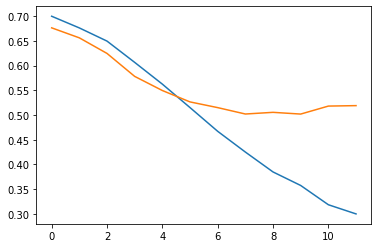

In [0]:
from matplotlib import pyplot as plt

plt.plot(range(len(epoch_losses)), epoch_losses, label='train error')
plt.plot(range(len(val_losses)), val_losses, label='val error')

### Calculate performance of the trained model (2 points)

In [0]:
batch_size = 8
accuracy = 0
true_positive = 0
false_negative = 0
false_positive = 0

model.eval()

for batch in test_iter:
    x = batch.text.to(device)
    y = batch.label.to(device)
    
    preds = model(x)
    preds = preds.argmax(dim=-1)
    
    accuracy += (preds == y).sum()
    true_positive += ((preds == y) * y * preds).sum()
    false_positive += ((preds != y) * (1 - y) * preds).sum()
    false_negative += ((preds != y) * y * (1 - preds)).sum()

In [0]:
accuracy = accuracy.item()
true_positive = true_positive.item()
false_positive = false_positive.item()
false_negative = false_negative.item()

In [0]:
accuracy = accuracy / batch_size / len(test_iter) * 100
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)

In [0]:
print('Accuracy {}%'.format(round(accuracy, 4)))
print('Precision {}'.format(round(precision, 4)))
print('Recall {}'. format(round(recall, 4)))
print('F1 {}'.format(round(2 * precision * recall / (precision + recall), 4)))

Accuracy 75.4116%
Precision 0.7358
Recall 0.7953
F1 0.7644


# All experements will be held inside one training session
### 1. Adding more convolution layers
### 2. Adding convolutions with different stride
### 3. Adding smart scheduler (the one from task-3 (RNN))

In [0]:
class CNNUPD(nn.Module):
    def __init__(self, V, D, kernel_sizes, batch_size=8, dropout=0.5, strides=4):
        super(CNNUPD, self).__init__()
        
        self.emb_dim = D
        self.voc_size = V
        self.p = dropout
        self.batch_size = batch_size
        if isinstance(kernel_sizes, (list, tuple)):
            self.kernel_sizes = kernel_sizes
        else:
            self.kernel_sizes = [kernel_sizes]

        if isinstance(strides, (list, tuple)):
            self.strides = strides
        else:
            self.strides = list(range(1, strides))

        self.emb = nn.Embedding(self.voc_size, self.emb_dim)
        self.conv = nn.ModuleList([nn.Conv1d(self.emb_dim, 1, 
                                  kernel_size=kernel_size, stride=stride) 
                                  for kernel_size, stride in 
                                  product(self.kernel_sizes, self.strides)])
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(self.p)
        self.fc = nn.Linear(len(self.conv), 2)
        
        
    def forward(self, x):
        x = self.emb(x).permute(0, 2, 1)
        new_x = [self.tanh(conv(x)).max(dim=-1)[0].squeeze().unsqueeze(dim=-1) for conv in self.conv]
        x = torch.cat(new_x, dim=-1)
        x = self.dropout(x)
        logit = self.fc(x)
        return logit

In [0]:
kernel_sizes = [3,4,5,6]
vocab_size = len(TEXT.vocab)
dim = 300

model1 = CNNUPD(vocab_size, dim, kernel_sizes, strides=5)

In [85]:
model1.cuda()

CNNUPD(
  (emb): Embedding(201052, 300)
  (conv): ModuleList(
    (0): Conv1d(300, 1, kernel_size=(3,), stride=(1,))
    (1): Conv1d(300, 1, kernel_size=(3,), stride=(2,))
    (2): Conv1d(300, 1, kernel_size=(3,), stride=(3,))
    (3): Conv1d(300, 1, kernel_size=(3,), stride=(4,))
    (4): Conv1d(300, 1, kernel_size=(4,), stride=(1,))
    (5): Conv1d(300, 1, kernel_size=(4,), stride=(2,))
    (6): Conv1d(300, 1, kernel_size=(4,), stride=(3,))
    (7): Conv1d(300, 1, kernel_size=(4,), stride=(4,))
    (8): Conv1d(300, 1, kernel_size=(5,), stride=(1,))
    (9): Conv1d(300, 1, kernel_size=(5,), stride=(2,))
    (10): Conv1d(300, 1, kernel_size=(5,), stride=(3,))
    (11): Conv1d(300, 1, kernel_size=(5,), stride=(4,))
    (12): Conv1d(300, 1, kernel_size=(6,), stride=(1,))
    (13): Conv1d(300, 1, kernel_size=(6,), stride=(2,))
    (14): Conv1d(300, 1, kernel_size=(6,), stride=(3,))
    (15): Conv1d(300, 1, kernel_size=(6,), stride=(4,))
  )
  (tanh): Tanh()
  (dropout): Dropout(p=0.5, inp

In [0]:
from math import floor

class SLTR:
    def __init__(self, training_iterations, cut_frac=0.1, ratio=32):
        self.training_iterations = training_iterations
        self.cut_frac = cut_frac
        self.ratio = ratio
        self.cut = floor(training_iterations * cut_frac)
    
    def __call__(self, it):
        if it < self.cut:
            p = it / self.cut
        else:
            p = 1 - (it - self.cut) / (self.cut * (1 / self.cut_frac - 1))
        return (1 + p * (self.ratio - 1)) / self.ratio

In [0]:
epochs=30

In [0]:
scheduler_func = SLTR(epochs * len(train_iter))
opt = optim.Adam(model1.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.LambdaLR(opt, lambda e: scheduler_func(e))
loss_func = nn.CrossEntropyLoss()

In [89]:
import datetime

epoch_losses1 = []
val_losses1 = []


for epoch in range(epochs):
    running_loss = 0.0
    running_corrects = 0
    model1.train() 
    for idx, batch in enumerate(train_iter): 
        x = batch.text
        y = batch.label
        
        opt.zero_grad()
        preds = model1(x).squeeze()
        loss = loss_func(preds, y)
        loss.backward()

        opt.step()
        scheduler.step()
        running_loss += loss.item()
            
    epoch_loss = running_loss / len(train_iter)
    
    val_loss = 0.0
    model1.eval()
    for batch in val_iter:
        x = batch.text
        y = batch.label
        
        preds = model1(x).squeeze()
        loss = loss_func(preds, y)
        val_loss += loss.item()
        
    val_loss /= len(val_iter)
    
    val_losses1.append(val_loss)
    epoch_losses1.append(epoch_loss)
    
    if epoch > 5 and sum(val_losses1[-3:]) / 3 > sum(val_losses1[-5:]) / 5:
      break

    print(epoch, datetime.datetime.now())

0 2020-03-29 13:21:46.853266
1 2020-03-29 13:24:08.387429
2 2020-03-29 13:26:29.797798
3 2020-03-29 13:28:51.078202
4 2020-03-29 13:31:12.466713
5 2020-03-29 13:33:33.578524
6 2020-03-29 13:35:54.961584
7 2020-03-29 13:38:16.207081


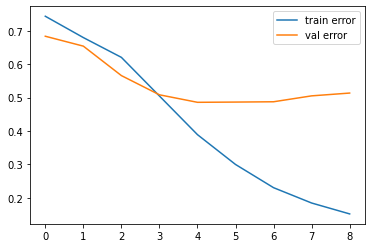

In [90]:
plt.plot(range(len(epoch_losses1)), epoch_losses1, label='train error')
plt.plot(range(len(val_losses1)), val_losses1, label='val error')
plt.legend()

In [0]:
batch_size = 8
accuracy1 = 0
true_positive1 = 0
false_negative1 = 0
false_positive1 = 0

model1.eval()

for batch in test_iter:
    x = batch.text
    y = batch.label
    
    preds = model1(x)
    preds = preds.argmax(dim=-1)
    
    accuracy1 += (preds == y).sum()
    true_positive1 += ((preds == y) * y * preds).sum()
    false_positive1 += ((preds != y) * (1 - y) * preds).sum()
    false_negative1 += ((preds != y) * y * (1 - preds)).sum()

In [0]:
accuracy1 = accuracy1.item()
true_positive1 = true_positive1.item()
false_positive1 = false_positive1.item()
false_negative1 = false_negative1.item()

In [0]:
accuracy1 = accuracy1 / batch_size / len(test_iter) * 100
precision1 = true_positive1 / (true_positive1 + false_positive1)
recall1 = true_positive1 / (true_positive1 + false_negative1)

In [96]:
print('Accuracy {}%'.format(round(accuracy1, 4)))
print('Precision {}'.format(round(precision1, 4)))
print('Recall {}'. format(round(recall1, 4)))
print('F1 {}'.format(round(2 * precision1 * recall1 / (precision1 + recall1), 4)))

Accuracy 76.92%
Precision 0.7622
Recall 0.7825
F1 0.7722


## We've improved our accuracy - it's 1,5% better now!